# Probabilistic Streaming

Streaming libraries in Haskell exist to represent streams of data where each incoming datapoint may involve a side-effect. 

In this notebook, we'll use the `pipes` library, which is not the fastest streaming library, but is simple and easy to use.

In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase


import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Density.Free
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Sequential.Coroutine
import Control.Monad.Bayes.Inference.SMC

import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)
import Control.Applicative
import qualified Data.Text as T
import Pipes (Producer, (>->))
import qualified Pipes as P
import Pipes.Prelude (unfoldr)
import qualified Pipes.Prelude as P
import Data.Ord
import Data.List
import Control.Monad
import Control.Arrow (first)
import Numeric.Log
import Data.Vector qualified as V

:e PackageImports
import "matrix" Data.Matrix hiding ((!))
import Data.Vector.Generic as VG (Vector, map, mapM, null, sum, (!))

:l ../plotting.hs

A `Producer` represents a stream of data, and a `Pipe` maps one stream to another. Both are parametrized by a monad `m`, which in our case will be `MonadDistribution m => m`. 

For example, a random walk with a Gaussian `transition` kernel can be written as follows:

In [2]:
-- how to move from one latent state to the next
transition :: MonadDistribution m => V.Vector Double -> m (V.Vector Double)
transition vector = mvNormal (fmap (+0.5) vector) (fromLists [[1,0], [0,1]])
    -- (normal (x+0.5) 1) (normal (y+0.5) 1)

-- a Markovian random walk starting at (0,0), with latentTransition as the kernel
-- a Producer is an infinite stream of values
prior :: MonadDistribution m => Producer (V.Vector Double) m r
prior = flip P.unfoldr (V.fromList [0,0]) $ \s ->
    Right <$> do
        new <- transition s
        return (new, new)

It's straightforward to take the first `n` steps of this infinite stream, and convert it into a distribution over finite list, from which we can then sample:

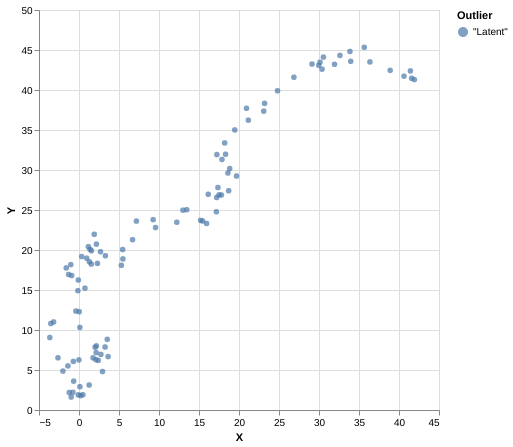

In [3]:
-- convert the stream to a list, taking only the first 100 steps
toList :: Monad m => P.Producer a m () -> m [a]
toList prod = P.toListM (prod >-> P.take 100)

trueVectors <- sampleIOfixed $ toList prior

plot 
    (zip 
        (fmap (\v -> (v V.! 0, v V.! 1)) $ trueVectors) 
        (replicate 100 (T.pack "Latent")))

We can also produce a stream of observations from `prior`, each a noisy perturbation of the datapoint in question, by using a `Pipe`:

In [4]:
observationModel = (`mvNormal` fromLists [[20,0],[0,20]])

observations :: MonadDistribution m => P.Pipe (V.Vector Double) (V.Vector Double) m ()
observations = P.mapM observationModel

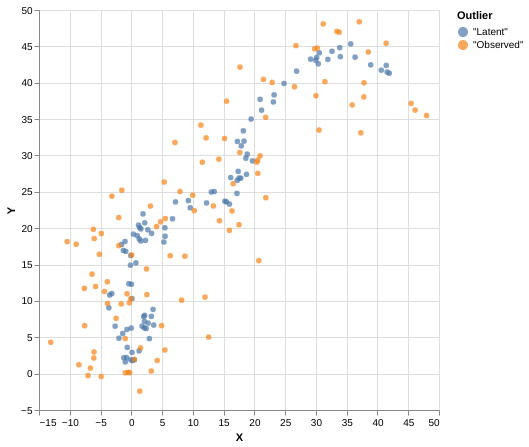

In [5]:
observedVectors <- sampleIOfixed $ toList $ P.each trueVectors >-> observations


plot 
    (zip 
        (fmap (\v -> (v V.! 0, v V.! 1)) $ trueVectors <> observedVectors) 
        (replicate 100 (T.pack "Latent") <> replicate 100 (T.pack "Observed")))

## Conditioning

But most interestingly, we can update our prior, based on a stream of incoming observations. `conditioning` below takes two `Producer`s, the stream corresponding to the prior (see `prior` above) and the stream corresponding to the observations (`P.each observedVectors`, where `P.each` lifts a list to a stream), and a likelihood, and returns a posterior, also expressed as a stream.  

In [6]:
-- take the original random walk as a prior and condition on the observations
-- to obtain a posterior random walk
conditioning :: MonadMeasure m => 
    P.Producer (V.Vector Double) m () -> 
    P.Producer (V.Vector Double) m () -> 
    ((V.Vector Double, V.Vector Double) -> m ()) ->
    P.Producer (V.Vector Double) m ()
conditioning prior observations observationModel = 
    P.zip prior observations
    >-> P.chain observationModel
    >-> P.map fst 


posterior :: MonadMeasure m => m [V.Vector Double]
posterior = toList $ conditioning 
    prior
    (P.each observedVectors)
    (\(v, v') -> do
        prediction <- observationModel v
        let (x, y, x', y') = (prediction V.! 0, prediction V.! 1, v' V.! 0, v' V.! 1)
        factor $ normalPdf x 2 x' * normalPdf y 2 y' )


We can then use an inference method of our liking:

In [7]:
particles <- sampleIOfixed $ runPopulationT $ 
    smc SMCConfig {
        numSteps = 100, 
        numParticles = 1000, 
        resampler = resampleMultinomial} 
    posterior

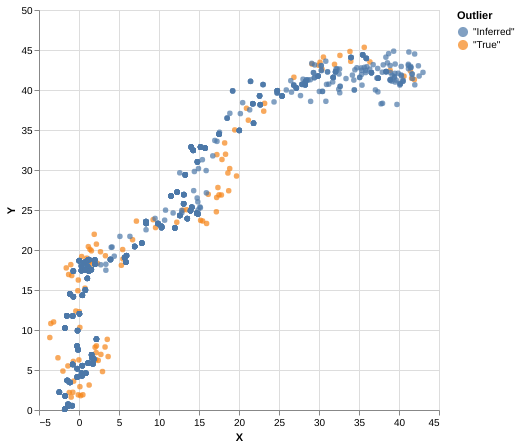

In [8]:
inferredVectors = fst =<< particles


plot 
    (zip 
        (fmap (\v -> (v V.! 0, v V.! 1)) $ trueVectors <> inferredVectors) 
        (replicate 100 (T.pack "True") <> replicate 1000 (T.pack "Inferred")))
